## 3) For each day of the week, what hour is the most active?
a. What reasons can you give for any difference between the days?
b. What type of data do you include/exclude? Explain.

In [1]:
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 100)

# tab delimited
df_all = pd.read_csv("sorted-AllTraffic.csv",sep='\t', lineterminator='\r',dtype='str')

In [2]:
df = df_all.drop(
        ['id','ident','asn','unixTimestamp','country_code','source_ip_num','normalized',
         'destination_ip_num'],axis=1)

In [3]:
# splitting into two DFs
df_unknowntz = df[(df['latitude'] == "None") | (df['longitude'] == "None") | (df['latitude'].isnull()) | (df['latitude'] == 'n/a')]
df = df[(df['latitude'] != "None") & (df['longitude'] != "None")  & ~df['latitude'].isnull() & (df['latitude'] != 'n/a')]

Timezone finder is needed to run the module  

conda config --add channels conda-forge  
conda install timezonefinder  


In [4]:
# adding timezone
from timezonefinder import TimezoneFinder
tf = TimezoneFinder()

df['timezone'] = df[['latitude','longitude']].astype(float).apply(lambda x: tf.timezone_at(lat=x[0],lng=x[1]),axis=1)

# a few oceanic countries weren't assigned timezone properly
df.loc[df.timezone.isnull(),'timezone'] = "Pacific/Majuro"

In [5]:
# set timestamp to UTC
df['timestamp'] = pd.to_datetime(df['timestamp']).dt.tz_localize('UTC')
# add new column 'localtime' based on timezone
df['localtime'] = df[['timestamp','timezone']].apply(lambda x:x[0].tz_convert(x[1]),axis=1)
# add new column 'localtime_notz' striping the timezone information
df['localtime_notz'] = pd.to_datetime(df['localtime'].astype(str).str[:-6])

In [6]:
# add 3 new columns (hour, minutes and seconds) with no timezones
df['localhour_notz'] = df['localtime_notz'].dt.hour
df['localminute_notz'] = df['localtime_notz'].dt.minute
df['localseconds_notz'] = df['localtime_notz'].dt.second
df['localweekday_notz'] = df['localtime_notz'].dt.weekday # The day of the week with Monday=0, Sunday=6

In [7]:
X = df.groupby(['localhour_notz']).size().index
y = df.groupby(['localhour_notz']).size().values

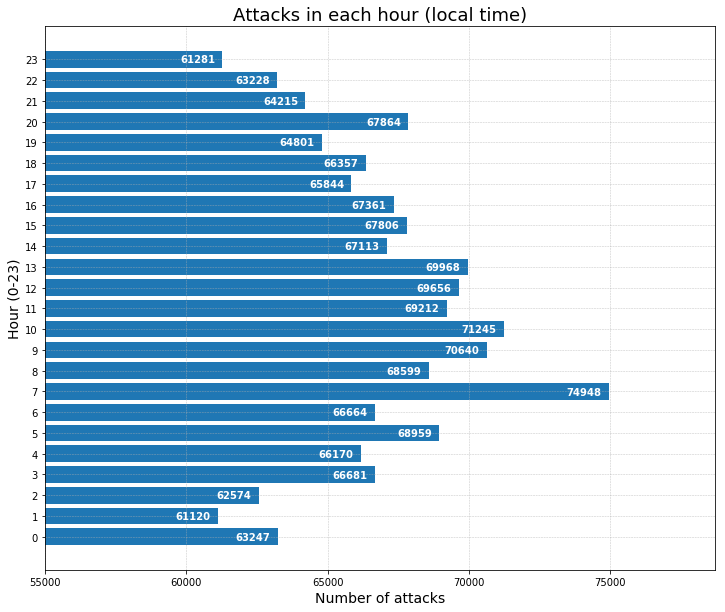

In [8]:
plt.barh(X, y,align='center')
plt.ylabel('Hour (0-23)', fontsize=14)
plt.xlabel('Number of attacks', fontsize=14)
plt.yticks(list(X))
plt.grid(linestyle='dashed', linewidth=.5, alpha=.75)
plt.title('Attacks in each hour (local time)', fontsize=18)
plt.xlim(55000,)
plt.gcf().set_size_inches(12, 10)

for i, v in enumerate(y):
    plt.text(v - 1500, i - .15, str(v), color='w', fontweight='bold')
plt.savefig("3.Attack_in_hour_local_time.png")    
plt.show()

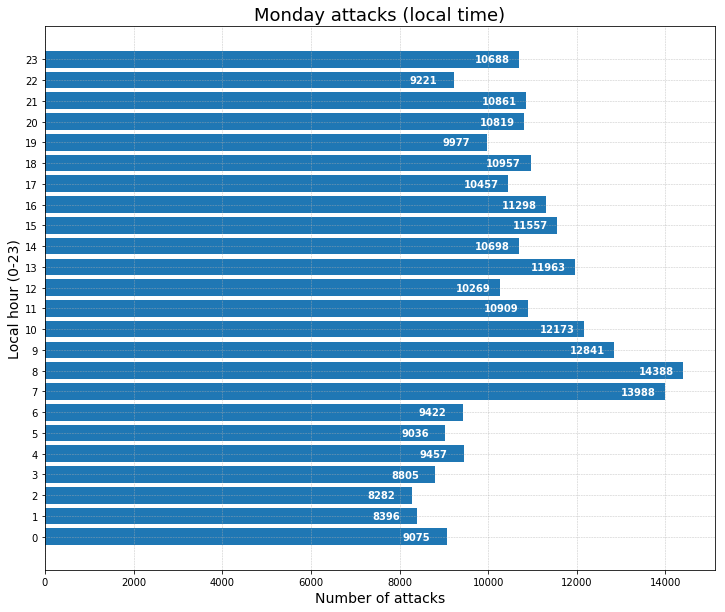

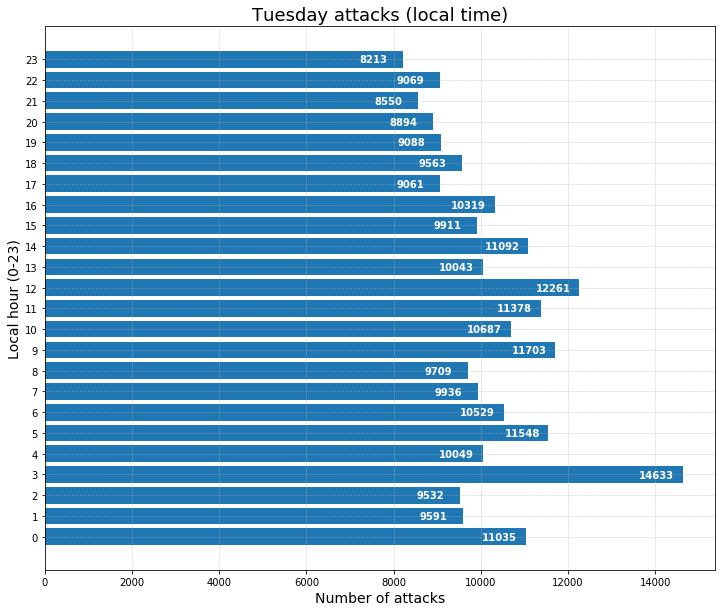

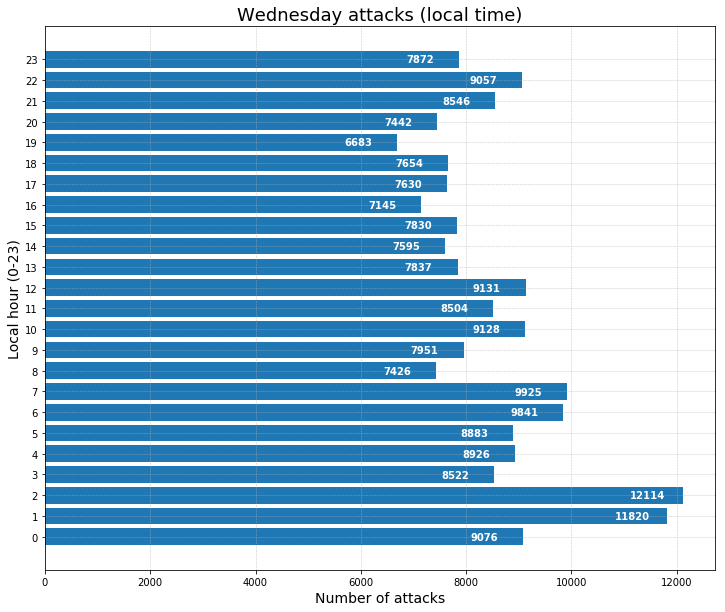

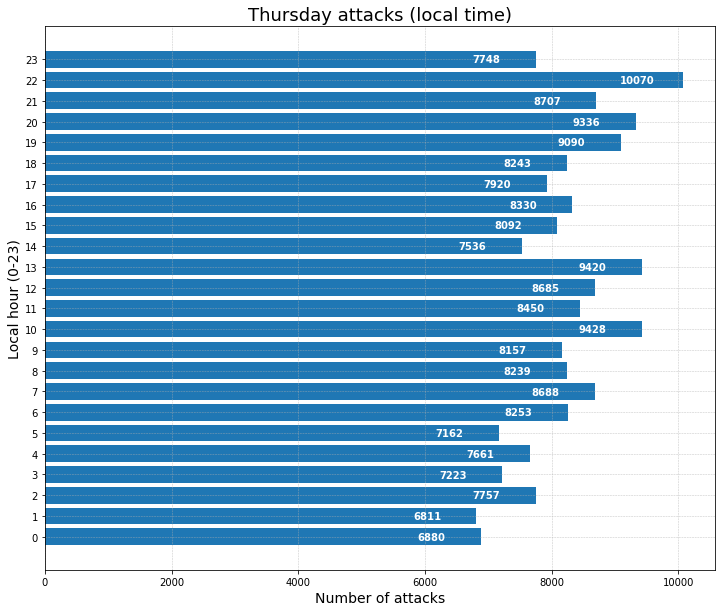

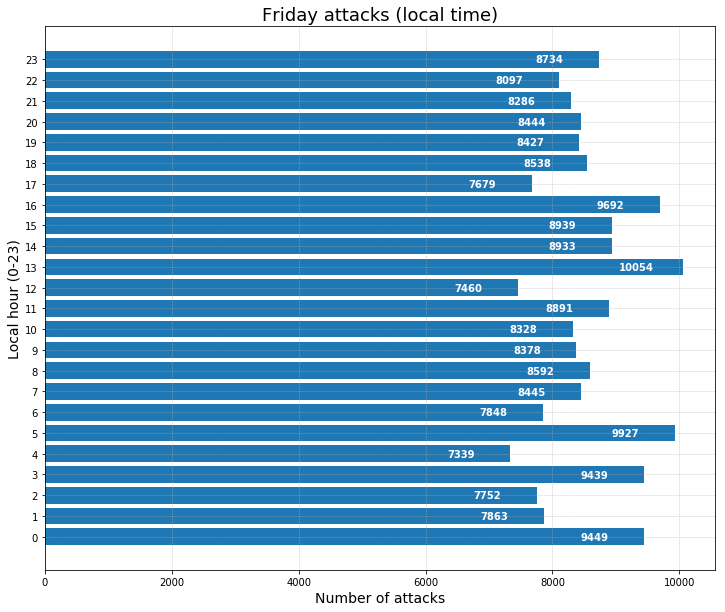

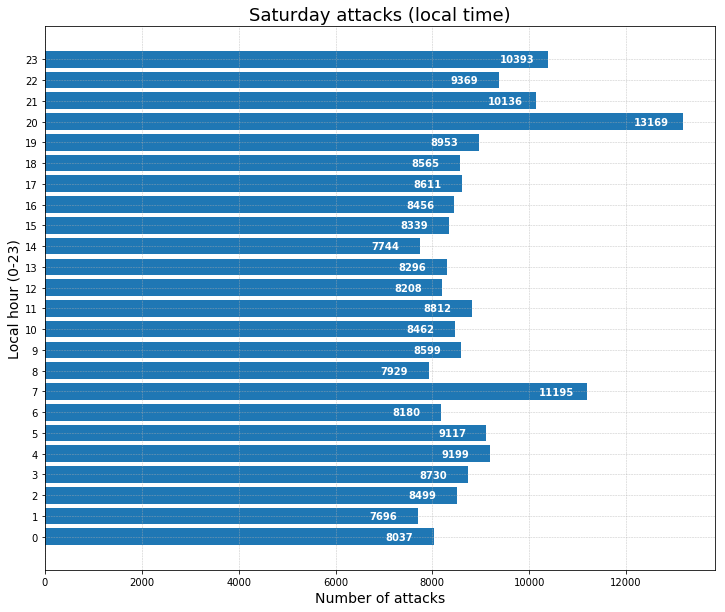

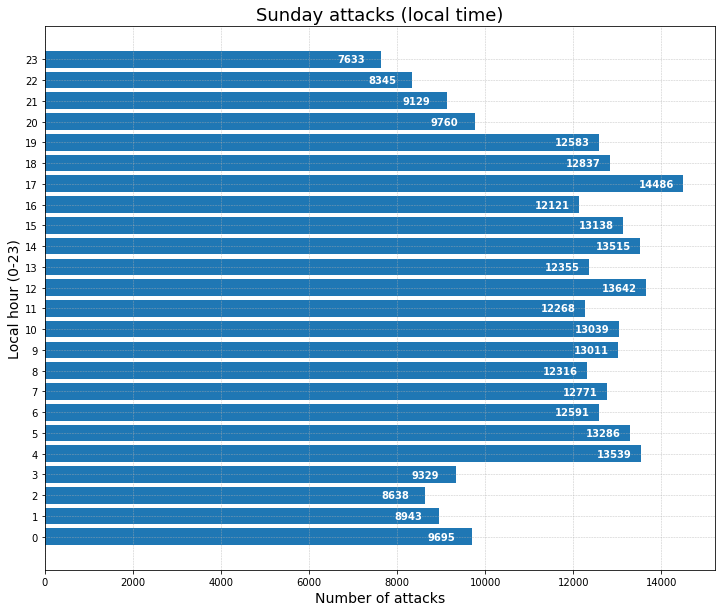

In [9]:
# importing calender day
import calendar
var_day = (calendar.day_name)

dayperhour = df.groupby(['localweekday_notz','localhour_notz']).size()

for i in range(7):
    fname = "3.weekdays_attack"+str(i)+".png"
    
    X = dayperhour[i].index
    y = dayperhour[i].values
    plt.barh(X, y,align='center')
    plt.ylabel('Local hour (0-23)', fontsize=14)
    plt.xlabel('Number of attacks', fontsize=14)
    plt.yticks(list(X))
    plt.grid(linestyle='dashed', linewidth=.5, alpha=.75)
    t = var_day[i]+' attacks (local time)'
    plt.title(t, fontsize=18)
    #plt.xlim(55000,)
    plt.gcf().set_size_inches(12, 10)

    for i, v in enumerate(y):
        plt.text(v - 1000, i - .15, str(v), color='w', fontweight='bold')
    plt.savefig(fname)
    
    plt.show()


In [10]:
weekday_X = df.groupby(['localweekday_notz']).size().index
weekday_y = df.groupby(['localweekday_notz']).size().values

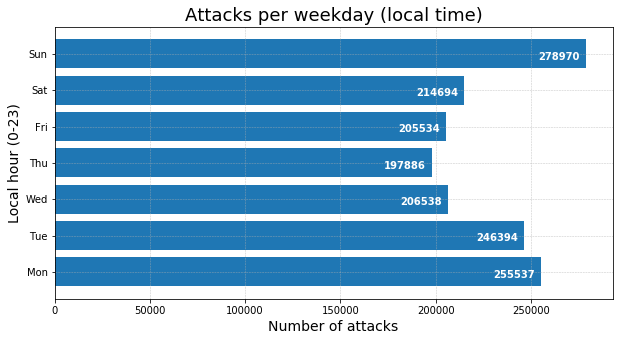

In [11]:
plt.barh(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], weekday_y,align='center')
plt.ylabel('Local hour (0-23)', fontsize=14)
plt.xlabel('Number of attacks', fontsize=14)
plt.grid(linestyle='dashed', linewidth=.5, alpha=.75)
plt.title('Attacks per weekday (local time)', fontsize=18)
plt.gcf().set_size_inches(10, 5)

for i, v in enumerate(weekday_y):
    plt.text(v - 25000, i - .15, str(v), color='w', fontweight='bold')
plt.savefig("3.Attacks_per_weekday_local.png")    
plt.show()